# Определение перспективного тарифа для телеком компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент федерального оператора сотовой связи хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

# Предобработка данных

## Общая информация

In [1]:
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from functools import reduce
idx = pd.IndexSlice
from scipy import stats as st

#calls = pd.read_csv("C:/Users/Миша/Documents/PythonYandex/Project3/calls.csv").loc[:,'id':'user_id']
#internet = pd.read_csv("C:/Users/Миша/Documents/PythonYandex/Project3/internet.csv").loc[:,'id':'user_id']
#messages = pd.read_csv("C:/Users/Миша/Documents/PythonYandex/Project3/messages.csv").loc[:,'id':'user_id']
#tariffs = pd.read_csv("C:/Users/Миша/Documents/PythonYandex/Project3/tariffs.csv").loc[:,'messages':'tariff_name']
#users = pd.read_csv("C:/Users/Миша/Documents/PythonYandex/Project3/users.csv").loc[:,'user_id':'tariff']

calls = pd.read_csv('C:/Users/Миша/Documents/PythonYandex/Project3/calls.csv', index_col=0)
internet = pd.read_csv('C:/Users/Миша/Documents/PythonYandex/Project3/internet.csv', index_col=0)
messages = pd.read_csv('C:/Users/Миша/Documents/PythonYandex/Project3/messages.csv', index_col=0)
tariffs = pd.read_csv('C:/Users/Миша/Documents/PythonYandex/Project3/tariffs.csv', index_col=0)
users = pd.read_csv('C:/Users/Миша/Documents/PythonYandex/Project3/users.csv', index_col=0)

for data in [calls, internet, messages, users, tariffs]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 7.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-N

Датасет содержит данные по 500 клиентам, потребуется заменить тип данных у столбцов с датой и временем, а также округлить значения минут разговора и мегабайт использованного трафика в большую сторону, так как тарифы считаются по минутам и мегабайтам.

Кроме того, после объединения данных (сводная таблица по звонкам, по сообщениям и интернет-трафику) возникнут пропущенные значения (клиент мог в каком-то месяце не писать сообщений, но звонить и использовать интернет), которые также нужно будет заменить на нули.

## Замена типа данных

Заменим тип данных, обозначающих дату, со строчного на временной:

In [2]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

## Исправление ошибок в данных

### Звонки

In [3]:
print('Количество звонков с длительностью, равной нулю:', calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с длительностью, равной нулю: 39613


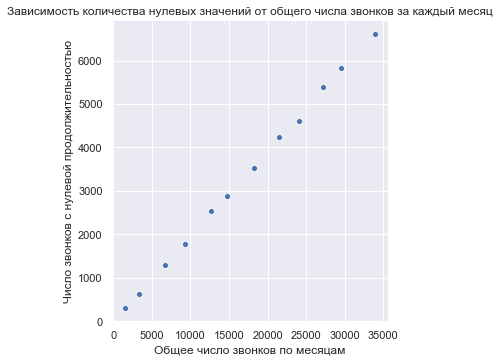

In [4]:
# добавим столбец со значением месяца
calls['month'] = calls['call_date'].dt.month

# построим график зависимости количества нулевых значений от общего числа звонков за каждый месяц
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1
null_calls = calls.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_calls['null_ratio'] = round(null_calls['nulls_count'] / null_calls['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_calls)
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой продолжительностью')
_ = plt.title('Зависимость количества нулевых значений от общего числа звонков за каждый месяц')

Таким образом, доля звонков с нулевой продолжительностью стационарна, и их появление систематично. Приведем все значения к виду int и добавим 1. 
1.Уберем все нули. 
2.Перевод в инт уберет все что стоит после запято не зависимо от того что там(Округление не подходит). 
3.После перевода в инт добавим по одной минуте к каждому числу, так как не важно что было после запятой.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202607 entries, 0 to 202606
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   id           202607 non-null  object        
 1   call_date    202607 non-null  datetime64[ns]
 2   duration     202607 non-null  int32         
 3   user_id      202607 non-null  int64         
 4   month        202607 non-null  int64         
 5   nulls_count  39613 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int32(1), int64(2), object(1)
memory usage: 10.0+ MB
AxesSubplot(0.125,0.125;0.775x0.755)


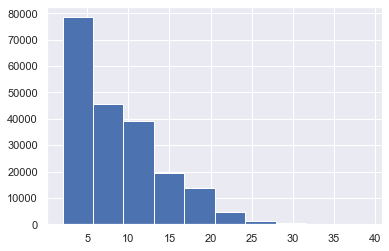

In [6]:
calls['duration'] = calls['duration'].astype('int') #переводим в инт
calls = calls.query('duration > 0') #убираем нули
calls['duration'] = calls['duration'] + 1 #добавляем по минуте так как при приращении в инт мы округлили до целых в меньшую сторону
#print(calls.head(10))
#print(calls[calls['duration'].isnull()])
calls.info() #проверяем что все нормально
print(calls['duration'].hist(bins = 10))

#### Интернет-сессии

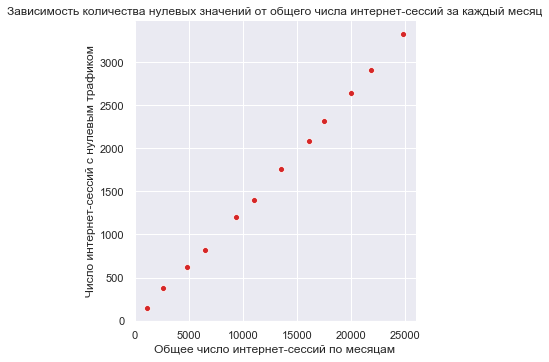

In [7]:
# добавим столбец со значением месяца
internet['month'] = internet['session_date'].dt.month

# построим график зависимости количества нулевых значений от общего числа Интернет-сессий за каждый месяц
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1
null_mb = internet.pivot_table(index='month', values=['id', 'nulls_count'], aggfunc='count')
null_mb['null_ratio'] = round(null_mb['nulls_count'] / null_mb['id'], 3)

sns.relplot(x='id', y='nulls_count', data=null_mb, color='tab:red')
plt.xlabel('Общее число интернет-сессий по месяцам')
plt.ylabel('Число интернет-сессий с нулевым трафиком')
_ = plt.title('Зависимость количества нулевых значений от общего числа интернет-сессий за каждый месяц')

Вывод по нулевым значениям интернет-сесссий аналогичен. Округлим все значения в большую сторону (т.к. тариф считается по мегабайтам), а нулевые значения заменим на 1.

In [8]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

## Расчетные значения для каждого пользователя

Найдем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам.

In [9]:
# для подсчета при создании сводной таблицы сгенерируем уникальный код из имени и населенного пункта
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']

# сводная таблица по звонкам
calls_temp = calls.merge(users, on='user_id', how='inner')
calls_grouped = calls_temp.pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

# сводная таблица по сообщениям
messages['month'] = messages['message_date'].dt.month
messages_temp = messages.merge(users, on='user_id', how='inner')
messages_grouped = messages_temp.pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

# сводная таблица по интернет-трафику
internet['month'] = internet['session_date'].dt.month
internet_temp = internet.merge(users, on='user_id', how='inner')
internet_grouped = internet_temp.pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['mb_used']

# объединяем все три сводные таблицы в одну
dfs = [calls_grouped, messages_grouped, internet_grouped]
grouped_data = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dfs)
grouped_data.head(10)

duration  calls  messages  mb_used
user_id month                                    
1000    5         186.0   22.0      22.0   2257.0
        6         230.0   43.0      60.0  23262.0
        7         393.0   47.0      75.0  14017.0
        8         470.0   52.0      81.0  14072.0
        9         536.0   58.0      57.0  14583.0
        10        420.0   57.0      73.0  14717.0
        11        387.0   43.0      58.0  14769.0
        12        387.0   46.0      70.0   9829.0
1001    11        503.0   59.0       NaN  18460.0
        12        493.0   63.0       NaN  14059.0

Теперь для каждого пользователя посчитаем помесячную выручку (вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану).

In [10]:
# пропущенные значения заменяем на нули
grouped_data.loc[grouped_data['duration'].isna(), 'duration'] = 0
grouped_data.loc[grouped_data['messages'].isna(), 'messages'] = 0
grouped_data.loc[grouped_data['mb_used'].isna(), 'mb_used'] = 0

# добавим наименование используемого тарифа для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']

# функция подсчета выручки с каждого пользователя в месяц
def det_revenue(row):
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[0, 'mg_per_month_included']
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_mb = mb_used - tariffs.loc[1, 'mg_per_month_included']
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_mb < 0: extra_mb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb'] / 1024) * extra_mb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

grouped_data['revenue'] = grouped_data.apply(det_revenue, axis=1)
grouped_data.head(10)

duration  calls  messages  mb_used tariff     revenue
user_id month                                                       
1000    5         186.0   22.0      22.0   2257.0  ultra  1950.00000
        6         230.0   43.0      60.0  23262.0  ultra  1950.00000
        7         393.0   47.0      75.0  14017.0  ultra  1950.00000
        8         470.0   52.0      81.0  14072.0  ultra  1950.00000
        9         536.0   58.0      57.0  14583.0  ultra  1950.00000
        10        420.0   57.0      73.0  14717.0  ultra  1950.00000
        11        387.0   43.0      58.0  14769.0  ultra  1950.00000
        12        387.0   46.0      70.0   9829.0  ultra  1950.00000
1001    11        503.0   59.0       0.0  18460.0  smart  1164.46875
        12        493.0   63.0       0.0  14059.0  smart   550.00000

# Анализ данных

Посчитаем, сколько в среднем каждому пользователю требуется минут, сообщений и мегабайт в месяц

In [11]:
medians = grouped_data.pivot_table(index='user_id', values=['duration', 'messages', 'mb_used', 'revenue'], aggfunc='median')
for user_id in users['user_id']:
    medians.loc[user_id, 'tariff'] = users.loc[user_id-1000, 'tariff']
medians.head()

,duration,mb_used,messages,revenue,tariff
user_id,,,,,
1000,390.0,14327.5,65.0,1950.000000,ultra
1001,498.0,16259.5,0.0,857.234375,smart
1002,254.0,17615.0,11.0,990.429688,smart
1003,959.0,11369.0,83.0,1950.000000,ultra
1004,157.0,17831.0,154.5,1950.000000,ultra


Найдем медиану, дисперсию и стандартное отклонение:

In [12]:
# описательная статистика:
medians.dropna(subset=['duration'], inplace=True)
desc_stat = medians.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages'], 
                    aggfunc={'duration': [np.median, np.var, np.std], 
                             'mb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
desc_stat

duration                              mb_used               \
         median         std            var    median          std   
tariff                                                              
smart     516.5  187.104534   35008.106510  16955.00  4181.498288   
ultra     629.5  354.039151  125343.720112  19751.75  8901.975727   

                     messages                          
                 var   median        std          var  
tariff                                                 
smart   1.748493e+07     28.5  28.010653   784.596662  
ultra   7.924517e+07     47.5  49.236809  2424.263318

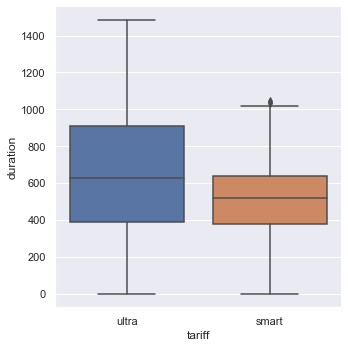

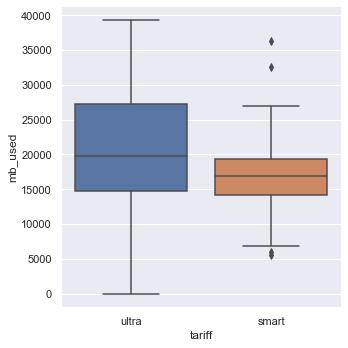

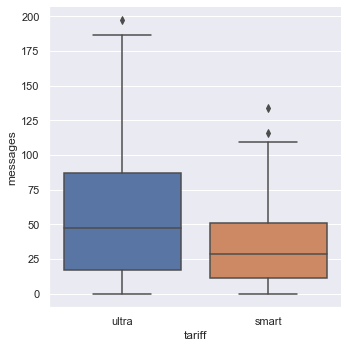

In [13]:
for column in ['duration', 'mb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=medians, orient='v')

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет **большую дисперсию** по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

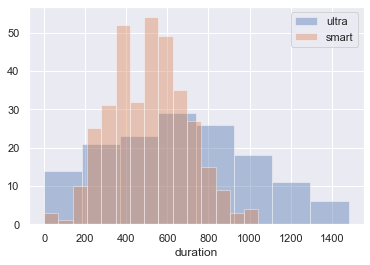

In [14]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['duration'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])

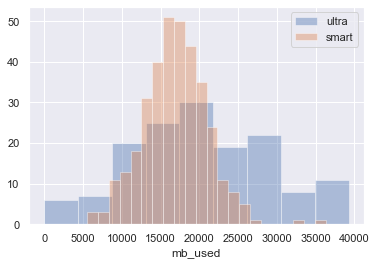

In [15]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['mb_used'], kde=False)
_ = plt.legend(['ultra', 'smart'])

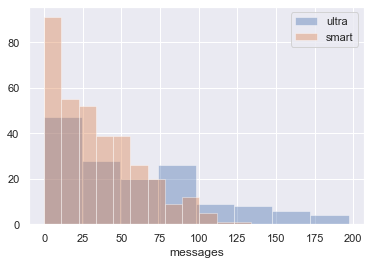

In [16]:
for tariff in ['ultra', 'smart']:
    sns.distplot(medians.query('tariff == @tariff')['messages'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])

По гистограммам наглядно видно, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. Также на гистограммах видно, что мода у "Смарта" явно выражена.

Другими словами, *поведение пользователей тарифа "Ультра" более разнообразное с точки зрения потребления телекоммуникационных услуг*. **Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета**: возможно, использование дорогого тарифа помогает им не думать о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора.

# Проверка гипотез

$H_0 $ — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».

$H_1 $ — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

$\alpha = 1\%$

In [17]:
ultra = grouped_data.query('tariff == "ultra"')['revenue']
smart = grouped_data.query('tariff == "smart"')['revenue']

alpha = .01

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.1202259436978366e-205
Отвергаем нулевую гипотезу


In [18]:
grouped_data.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,1135.0
ultra,1950.0


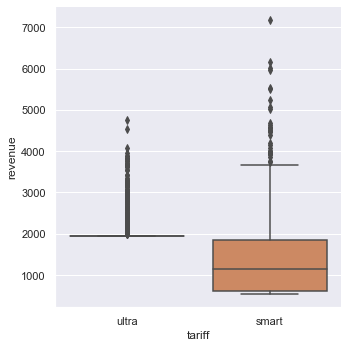

In [19]:
_ = sns.catplot(x="tariff", y='revenue', kind="box", data=grouped_data, orient='v')

Средние значения выручки по тарифам различаются почти в 2 раза. Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.

В заключение можно подтвердить **с уверенностью 99%, что доходы "Мегалайна" с пользователя по тарифу "Ультра" действительно отличаются по сравнению с доходами от тарифа "Смарт"**.

____
$H_0 $ — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

$H_1 $ — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.

$\alpha = 1\%$

In [20]:
# добавим наименование населенного пункта для каждого пользователя
for user in grouped_data.index:
    grouped_data.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

moscow = grouped_data.query('city == "Москва"')['revenue']
regions = grouped_data.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.7853783687870594
Не получилось отвергнуть нулевую гипотезу


In [21]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
grouped_data['region'] = grouped_data['city'].apply(det_region)
grouped_data.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1712.851562
Москва,1867.007812


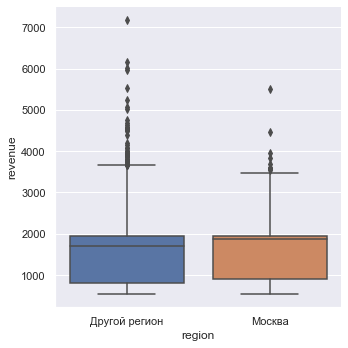

In [22]:
_ = sns.catplot(x="region", y='revenue', kind="box", data=grouped_data, orient='v')

Данный статистический тест не дал возможности опровергунть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Действительно, доходы в Московском регионе практически не отличаются от других населенных пунктов.

Если бы мы отклонили нулевую гипотезу и констатировали, что доходы "Мегалайна" с каждого пользователя в Москве отличаются от доходов в других регионах, мы бы с вероятностью 50,3% ошиблись.

# Общий вывод

По результатам статистического анализа доходы от тарифа «Ультра» больше, чем от тарифа «Смарт»: в среднем «Мегалайн» от одного пользователя в месяц получает 1950 рублей и 988 рублей соответственно $(p-значение = o(1)$, $\alpha = 1\%)$.

Особенности использования тарифов заключаются в следующем:
- *Пользователям тарифа «Смарт»* не хватает услуг в рамках тарифного пакета: кроме абонентской платы пользователи *в среднем доплачивают еще 438 рублей ежемесячно (+79,6%)*. 
- *Пользователи тарифа «Ультра»*, напротив, не используют тарифный пакет в полном объеме.
- Средние доходы от пользователей в Москве *не отличаются* от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,503) и составляет *188 руб.: 1734 руб. в Москве против 1546 руб в других населенных пунктах*.